In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.animation as animation

from IPython.display import HTML

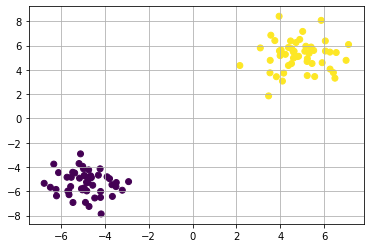

In [11]:
# Set the data X
X = []
labels = []

X.extend(np.random.normal(loc=[-5, -5], size=(50, 2)))
labels.extend([0 for _ in range(50)])
X.extend(np.random.normal(loc=[5, 5], size=(50, 2)))
labels.extend([1 for _ in range(50)])

X = np.array(X)

plt.scatter(X[:,0], X[:,1], c=labels)
plt.grid()
plt.show()

In [12]:
# Set random weights with the same dimensions as the data
# ... or set weights as grid
W = np.random.random(size=X.shape)

In [13]:
# Use networkx to define topology and neighbourhood connections
# The i'th row of the weights maps to the i'th node in the network

# Using a lattice as an example
s = int(np.ceil(np.sqrt(W.shape[0])))
G = nx.grid_2d_graph(m=s, n=s)

# Map coordinates to index and index to coordinates
c2i = {c: i for i, c in enumerate(G.nodes())}
i2c = {v: k for k, v in c2i.items()}

In [14]:
# If there are more nodes than weights, append difference to match size
diff = np.abs(len(G.nodes()) - W.shape[0])
if diff > 0:
    W = np.concatenate([W, np.random.random(size=(diff, W.shape[1]))])

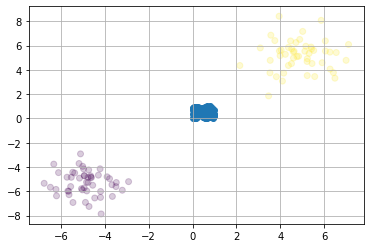

In [15]:
# Display with weights
plt.scatter(X[:,0], X[:,1], alpha=0.2, c=labels)
plt.scatter(W[:,0], W[:,1])
plt.grid()
plt.show()

In [16]:
# Function for learning rate
def f1(x, k):
    return np.exp(x * k)

# Function for neighbourhood restraint
def f2(x, s):
    return np.exp((x / (s ** 2)) * -1)

# Compute learning rate
def learning_rate(s, k):
    return f1(x=s, k=k)

# Compute neighbourhood restraint
def restraint(G, best, n, sigma=4):
    dist = nx.shortest_path_length(G, source=best, target=n)
    return np.exp((dist / (sigma ** 2)) * -1)
    return f2(dist, s=sigma)

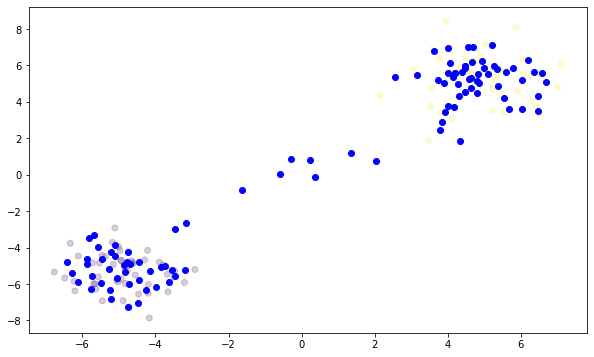

In [17]:
max_iter = 10000
max_per_frame = 100

figures = []

fig, ax = plt.subplots(figsize=(10, 6))

# Start training loop
for s in range(max_iter):
    # Pick random data point
    r_idx = np.random.randint(X.shape[0])
    x = X[r_idx, :]

    # Find the best matching unit (BMU) using Euclidean distance
    x_stack = np.stack([x]*W.shape[0], axis=0)
    dists = np.linalg.norm(x_stack - W, axis=1)
    best_idx = np.argmin(dists)

    # Set learning rate
    k = -(1/1000)
    a = learning_rate(s, k)
    
    # Update weights
    W[best_idx, :] = W[best_idx, :] + a * (x - W[best_idx, :])

    # Update weights of neighbours
    immediate_n = list(G[i2c[best_idx]])
    for n in immediate_n:
        W[c2i[n], :] = W[c2i[n], :] + restraint(G, i2c[best_idx], n) * a * (x - W[c2i[n], :])
    
    if s % max_per_frame == 0:
        fig1 = ax.scatter(X[:,0], X[:,1], alpha=0.2, c=labels, animated=True)
        fig2 = ax.scatter(W[:,0], W[:,1], c='b', animated=True)
        
        figures.append([fig1, fig2])

ani = animation.ArtistAnimation(fig, figures, interval=50)#, blit=True, repeat_delay=1000)

HTML(ani.to_jshtml())

In [18]:
ani.save('animation.gif', fps=60)